# Customer Churn Analysis

This notebook performs comprehensive analysis of customer churn patterns including:
- Exploratory Data Analysis (EDA)
- Churn prediction modeling
- Customer segmentation
- Feature importance analysis

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Custom imports
import sys
sys.path.append('../src')
from data_loader import ChurnDataLoader

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Initial Exploration

In [5]:
# Load data
loader = ChurnDataLoader()
df_raw = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

if df_raw is not None:
    print("Dataset shape:", df_raw.shape)
    print("\nFirst few rows:")
    display(df_raw.head())
    
    print("\nDataset info:")
    df_raw.info()

Dataset shape: (7043, 21)

First few rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,C0001,Male,0,No,No,2,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Mailed check,51.29,108.40,Yes
1,C0002,Female,1,No,No,7,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),106.47,692.63,Yes
2,C0003,Male,0,No,No,19,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),32.49,593.21,No
3,C0004,Male,0,Yes,No,43,Yes,No,Fiber optic,No,...,No,Yes,No,Yes,One year,Yes,Electronic check,96.15,4162.66,No
4,C0005,Male,0,Yes,No,4,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Two year,No,Electronic check,78.94,292.25,No



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-

In [6]:
# Preprocess data
df = loader.preprocess_data(df_raw)

# Get data summary
summary = loader.get_data_summary(df)
print("Data Summary:")
for key, value in summary.items():
    if key != 'missing_values':
        print(f"{key}: {value}")

print("\nMissing values:")
missing_vals = df.isnull().sum()
print(missing_vals[missing_vals > 0])

Data Summary:
total_customers: 7043
churned_customers: 3013
churn_rate: 0.42780065313076815
avg_tenure: 19.12011926735766
avg_monthly_charges: 67.61729376686071
avg_total_charges: 1300.0302285957687

Missing values:
Series([], dtype: int64)


## 2. Exploratory Data Analysis

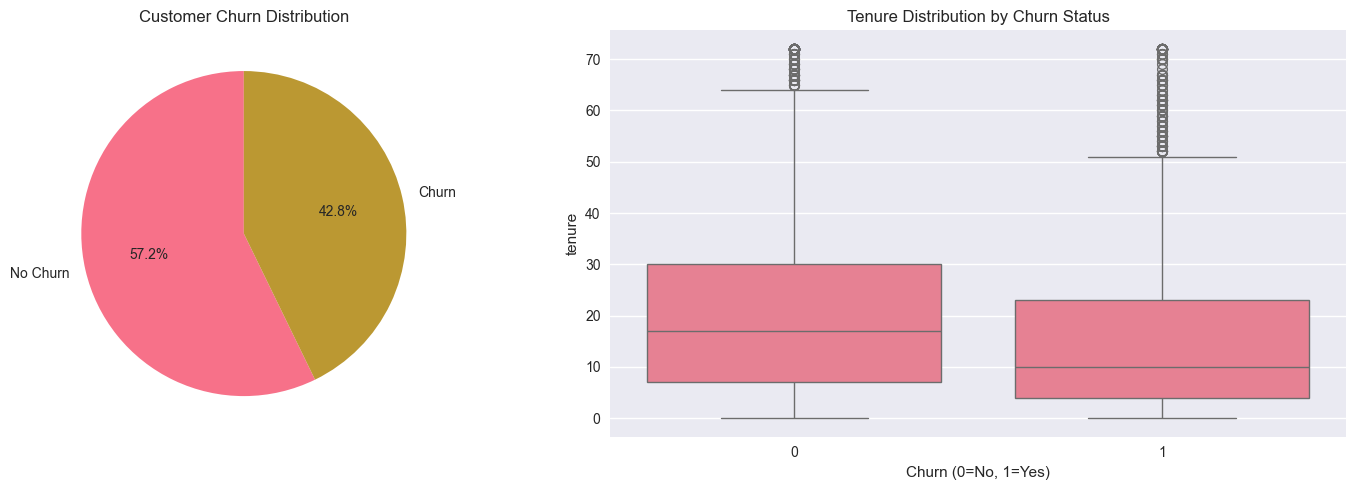

In [7]:
# Churn distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Churn count
churn_counts = df['Churn'].value_counts()
axes[0].pie(churn_counts.values, labels=['No Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Customer Churn Distribution')

# Churn by tenure
sns.boxplot(data=df, x='Churn', y='tenure', ax=axes[1])
axes[1].set_title('Tenure Distribution by Churn Status')
axes[1].set_xlabel('Churn (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

Churn Analysis by Spending Segment:


,SpendingSegment,TotalCustomers,ChurnedCustomers,ChurnRate
0,Low Spender,1127,401,35.581189
1,Medium Spender,1500,574,38.266667
2,High Spender,4416,2038,46.150362


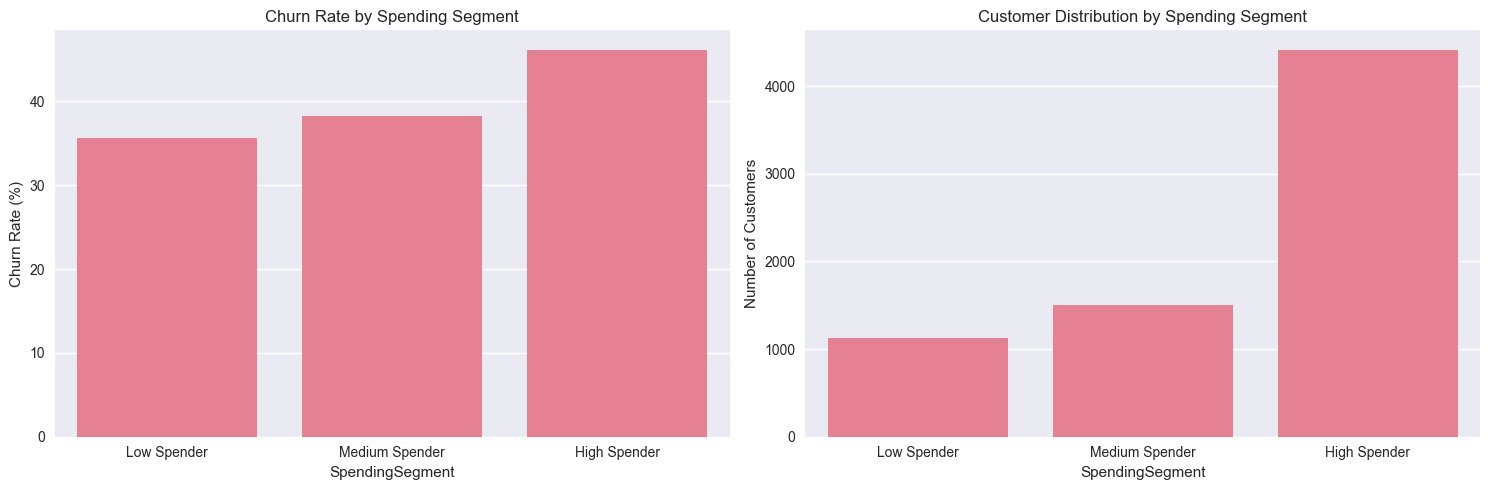

In [8]:
# High-paying vs Low-paying customer analysis
# Define spending segments
df['SpendingSegment'] = pd.cut(df['MonthlyCharges'], 
                              bins=[0, 35, 65, float('inf')], 
                              labels=['Low Spender', 'Medium Spender', 'High Spender'])

# Churn analysis by spending segment
spending_churn = df.groupby('SpendingSegment')['Churn'].agg(['count', 'sum', 'mean']).reset_index()
spending_churn.columns = ['SpendingSegment', 'TotalCustomers', 'ChurnedCustomers', 'ChurnRate']
spending_churn['ChurnRate'] = spending_churn['ChurnRate'] * 100

print("Churn Analysis by Spending Segment:")
display(spending_churn)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Churn rate by spending segment
sns.barplot(data=spending_churn, x='SpendingSegment', y='ChurnRate', ax=axes[0])
axes[0].set_title('Churn Rate by Spending Segment')
axes[0].set_ylabel('Churn Rate (%)')

# Customer distribution by spending segment
sns.barplot(data=spending_churn, x='SpendingSegment', y='TotalCustomers', ax=axes[1])
axes[1].set_title('Customer Distribution by Spending Segment')
axes[1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

## 3. Contract and Service Analysis

In [9]:
# Contract type analysis
contract_analysis = df.groupby(['Contract', 'Churn']).size().unstack(fill_value=0)
contract_analysis['ChurnRate'] = contract_analysis[1] / (contract_analysis[0] + contract_analysis[1]) * 100

print("Churn Analysis by Contract Type:")
display(contract_analysis)

# Internet service analysis
internet_analysis = df.groupby(['InternetService', 'Churn']).size().unstack(fill_value=0)
internet_analysis['ChurnRate'] = internet_analysis[1] / (internet_analysis[0] + internet_analysis[1]) * 100

print("\nChurn Analysis by Internet Service:")
display(internet_analysis)

Churn Analysis by Contract Type:


Churn,0,1,ChurnRate
Contract,,,
Month-to-month,1619,2185,57.439537
One year,1159,409,26.084184
Two year,1252,419,25.074806



Churn Analysis by Internet Service:


Churn,0,1,ChurnRate
InternetService,,,
DSL,1429,913,38.983775
Fiber optic,1603,1545,49.078780
No,998,555,35.737283


## 2. Exploratory Data Analysis

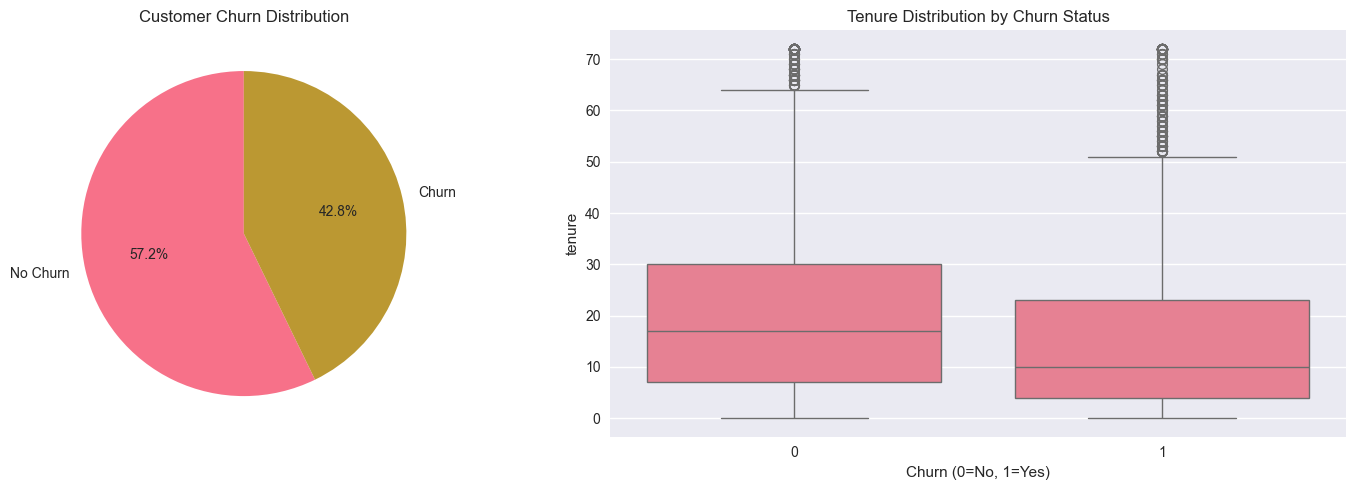

In [10]:
# Churn distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Churn count
churn_counts = df['Churn'].value_counts()
axes[0].pie(churn_counts.values, labels=['No Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Customer Churn Distribution')

# Churn by tenure
sns.boxplot(data=df, x='Churn', y='tenure', ax=axes[1])
axes[1].set_title('Tenure Distribution by Churn Status')
axes[1].set_xlabel('Churn (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

## 4. Machine Learning - Churn Prediction

In [11]:
# Prepare data for machine learning
# Select features for modeling
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                       'PaperlessBilling', 'PaymentMethod']

numerical_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

# Create feature matrix
df_model = df.copy()

# Encode categorical variables
le_dict = {}
for col in categorical_features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    le_dict[col] = le

# Prepare features and target
X = df_model[categorical_features + numerical_features]
y = df_model['Churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Churn rate in training set: {y_train.mean():.2%}")

Training set shape: (5634, 19)
Test set shape: (1409, 19)
Churn rate in training set: 42.78%


In [12]:
# Logistic Regression Model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_scaled)
rf_pred = rf_model.predict(X_test)

lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Model evaluation
print("Logistic Regression Results:")
print(f"Accuracy: {lr_model.score(X_test_scaled, y_test):.3f}")
print(f"AUC-ROC: {roc_auc_score(y_test, lr_pred_proba):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

print("\n" + "="*50)
print("Random Forest Results:")
print(f"Accuracy: {rf_model.score(X_test, y_test):.3f}")
print(f"AUC-ROC: {roc_auc_score(y_test, rf_pred_proba):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

Logistic Regression Results:
Accuracy: 0.677
AUC-ROC: 0.735

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       806
           1       0.64      0.57      0.60       603

    accuracy                           0.68      1409
   macro avg       0.67      0.66      0.67      1409
weighted avg       0.67      0.68      0.67      1409


Random Forest Results:
Accuracy: 0.676
AUC-ROC: 0.726

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.75      0.73       806
           1       0.63      0.58      0.60       603

    accuracy                           0.68      1409
   macro avg       0.67      0.66      0.67      1409
weighted avg       0.67      0.68      0.67      1409



## 5. Feature Importance Analysis

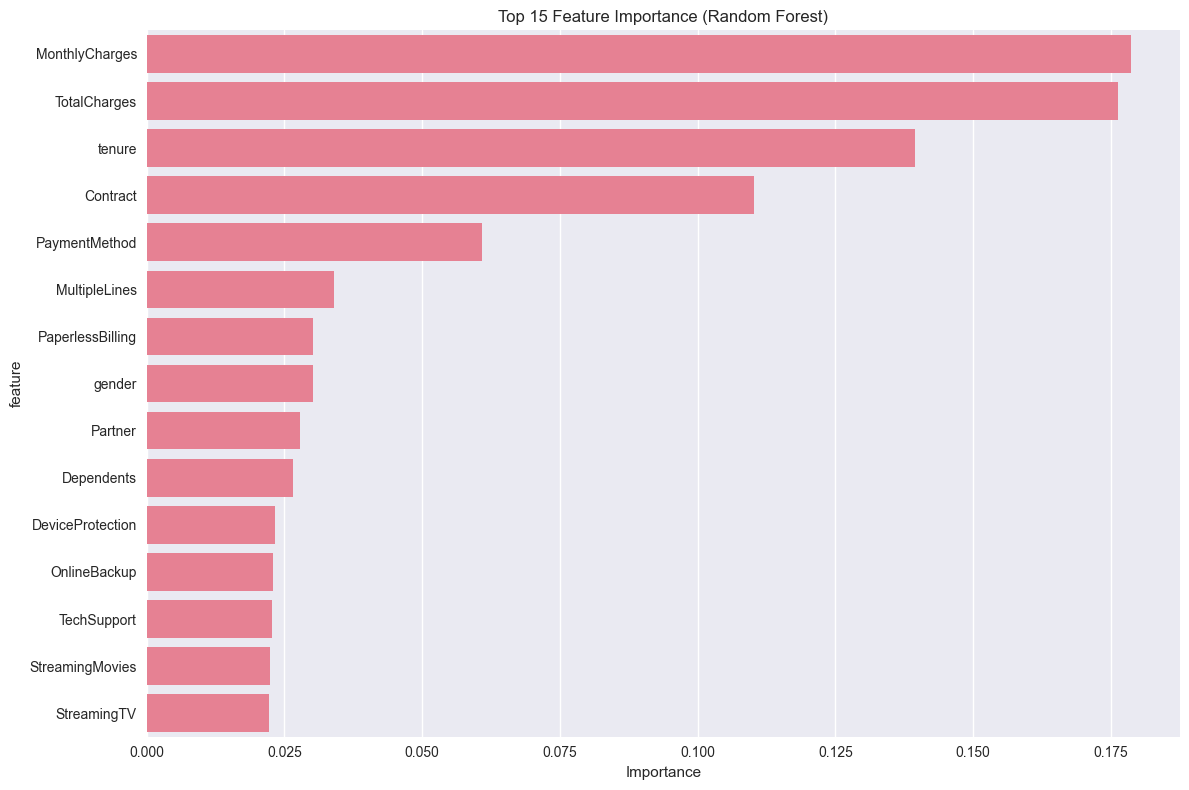

Top 10 Most Important Features:


,feature,importance
17,MonthlyCharges,0.178613
18,TotalCharges,0.176203
16,tenure,0.139425
12,Contract,0.110222
14,PaymentMethod,0.060938
4,MultipleLines,0.033965
13,PaperlessBilling,0.030150
0,gender,0.030149
1,Partner,0.027773
2,Dependents,0.026517


In [13]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), y='feature', x='importance')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
display(feature_importance.head(10))

## 6. Customer Segmentation with KMeans

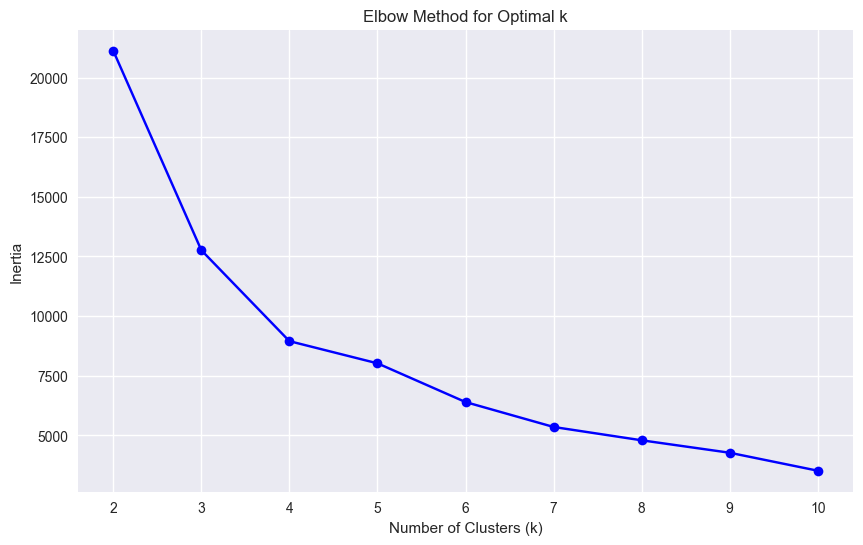

Customer segmentation completed with 4 clusters


In [14]:
# Prepare data for clustering
clustering_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
X_cluster = df[clustering_features].copy()

# Scale features for clustering
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Apply KMeans with optimal k (let's use 4 clusters)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

print(f"Customer segmentation completed with {optimal_k} clusters")

Cluster Analysis:


,CustomerCount,ChurnedCustomers,ChurnRate,AvgTenure,AvgMonthlyCharges,AvgTotalCharges,SeniorCitizenRate
Cluster,,,,,,,
0,1527,528,0.35,16.35,34.76,555.29,0.00
1,3358,1530,0.46,11.13,79.21,880.03,0.00
2,1006,538,0.53,15.89,65.97,992.67,1.00
3,1152,417,0.36,48.91,78.82,3779.87,0.07


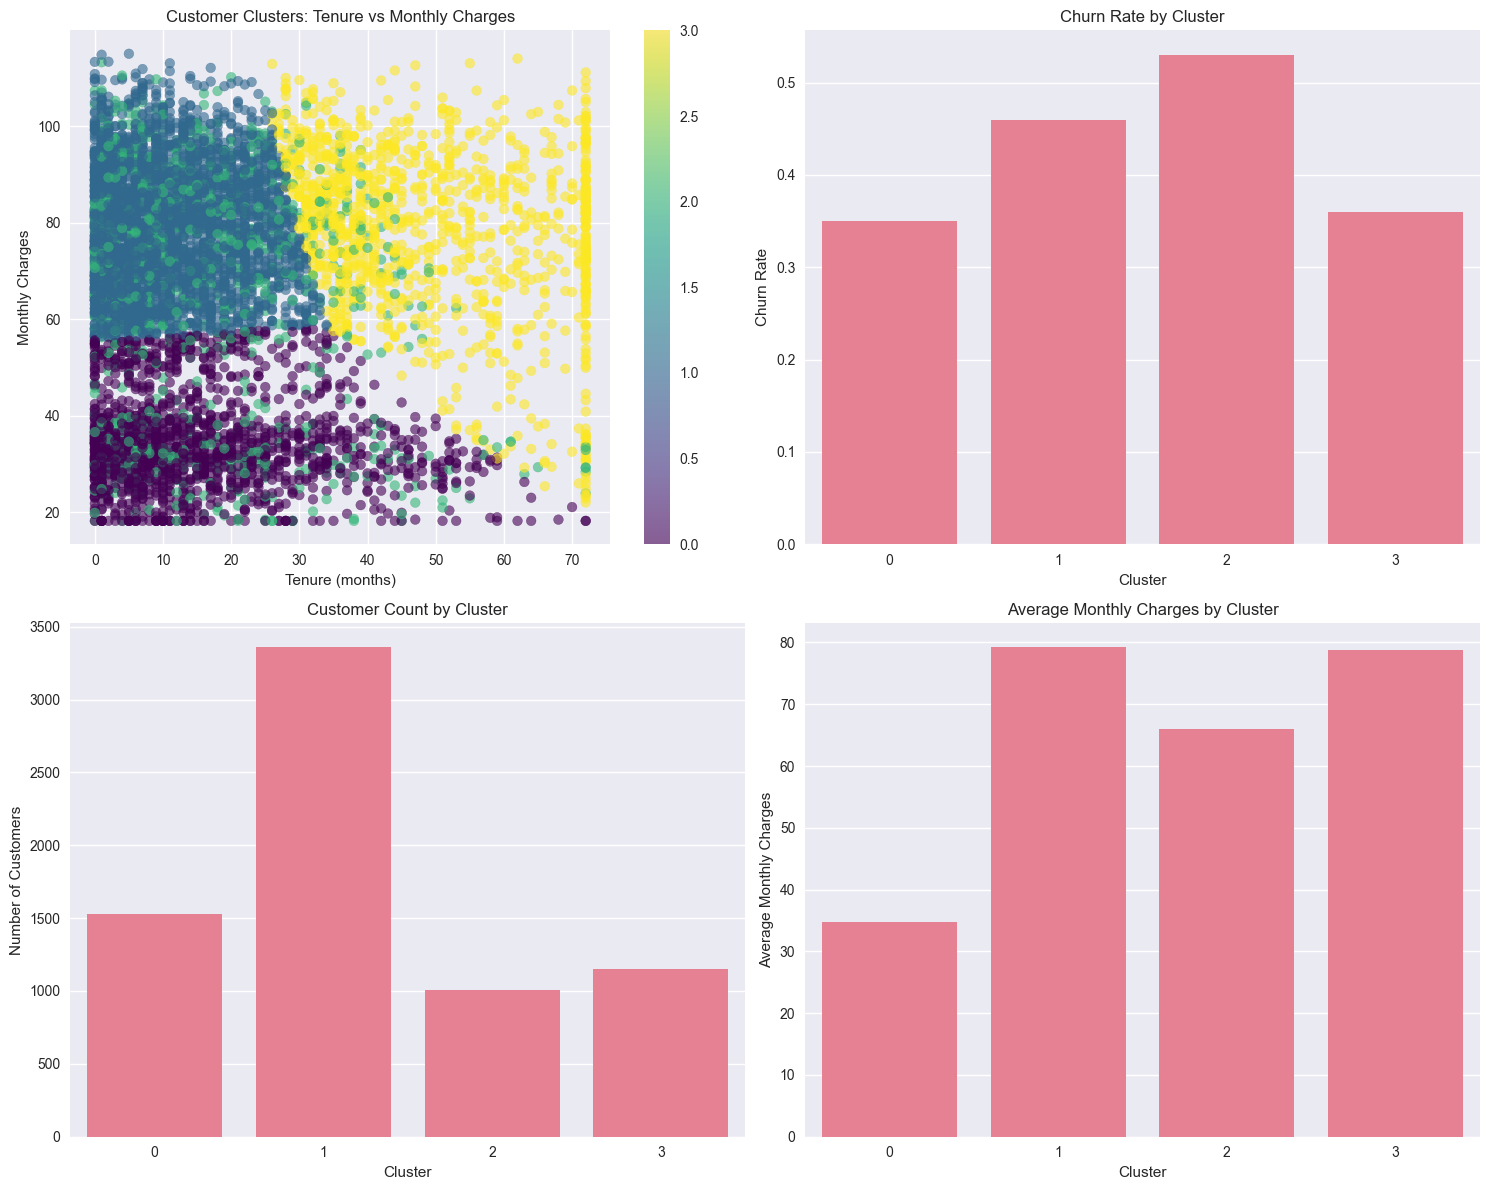

In [15]:
# Analyze clusters
cluster_analysis = df.groupby('Cluster').agg({
    'customerID': 'count',
    'Churn': ['sum', 'mean'],
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean',
    'SeniorCitizen': 'mean'
}).round(2)

cluster_analysis.columns = ['CustomerCount', 'ChurnedCustomers', 'ChurnRate', 
                           'AvgTenure', 'AvgMonthlyCharges', 'AvgTotalCharges', 'SeniorCitizenRate']

print("Cluster Analysis:")
display(cluster_analysis)

# Visualize clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Cluster by tenure and monthly charges
scatter = axes[0,0].scatter(df['tenure'], df['MonthlyCharges'], c=df['Cluster'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('Tenure (months)')
axes[0,0].set_ylabel('Monthly Charges')
axes[0,0].set_title('Customer Clusters: Tenure vs Monthly Charges')
plt.colorbar(scatter, ax=axes[0,0])

# Churn rate by cluster
sns.barplot(data=cluster_analysis.reset_index(), x='Cluster', y='ChurnRate', ax=axes[0,1])
axes[0,1].set_title('Churn Rate by Cluster')
axes[0,1].set_ylabel('Churn Rate')

# Customer count by cluster
sns.barplot(data=cluster_analysis.reset_index(), x='Cluster', y='CustomerCount', ax=axes[1,0])
axes[1,0].set_title('Customer Count by Cluster')
axes[1,0].set_ylabel('Number of Customers')

# Average monthly charges by cluster
sns.barplot(data=cluster_analysis.reset_index(), x='Cluster', y='AvgMonthlyCharges', ax=axes[1,1])
axes[1,1].set_title('Average Monthly Charges by Cluster')
axes[1,1].set_ylabel('Average Monthly Charges')

plt.tight_layout()
plt.show()